In [1]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

from network.model import AttentionWalkLayer
from utils import read_graph, feature_calculator, adjacency_opposite_calculator

In [2]:
epochs = 300
embedd_dim = 128
num_of_walks = 80
beta = 0.5
gamma = 0.5

In [3]:
graph = read_graph('./input/cora_edges.csv')
labels = pd.read_csv('./input/cora_target.csv', index_col = 'id').values.ravel()

target_tensor = feature_calculator(window_size = 5, graph=graph)
target_tensor = torch.FloatTensor(target_tensor)
adjacency_opposite = adjacency_opposite_calculator(graph)
adjacency_opposite = torch.FloatTensor(adjacency_opposite)

model = AttentionWalkLayer(embedd_dim, num_of_walks, beta, gamma, target_tensor.shape)

Adjacency matrix powers: 100%|██████████| 4/4 [00:00<00:00, 110.72it/s]


Target matrix creation started.



In [4]:
print("\nTraining the model.\n")
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = trange(epochs, desc="Loss")
best_loss = 9999
n_rounds = 3
k = 0
for epoch in epochs:
    optimizer.zero_grad()
    loss = model(target_tensor, adjacency_opposite)
    loss.backward()
    optimizer.step()
    epochs.set_description("Attention Walk (Loss=%g)" % round(loss.item(),4))
    # early stopping
    if best_loss > loss.item():
        best_loss = float(loss.item())
        k = k + 1
    elif n_rounds < k or np.isnan(loss.item()):
        break

Loss:   0%|          | 0/300 [00:00<?, ?it/s]


Training the model.



Attention Walk (Loss=76.1303): 100%|██████████| 300/300 [01:42<00:00,  2.87it/s]


In [5]:
left = model.left_factors.detach().numpy()
right = model.right_factors.detach().numpy().T
indices = np.array([range(len(graph))]).reshape(-1,1)

print("\nSaving the model.\n")
embedding = np.concatenate([indices, left, right], axis = 1)
columns = ["id" ] + ["x_" + str(x) for x in range(embedd_dim)]
embedding = pd.DataFrame(embedding, columns = columns)
embedding.to_csv('./output/cora_embedding.csv', index = None)


Saving the model.



In [6]:
attention = model.attention_probs.detach().numpy()
indices = np.array([range(5)]).reshape(-1,1)
attention = np.concatenate([indices, attention], axis = 1)
attention = pd.DataFrame(attention, columns = ["Order","Weight"])
attention.to_csv('./output/cora_attention.csv', index = None)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [8]:
proj = TSNE(n_components = 6, method = 'exact').fit_transform(embedding[["x_" + str(x) for x in range(embedd_dim)]].values)

True number of clusters is 6


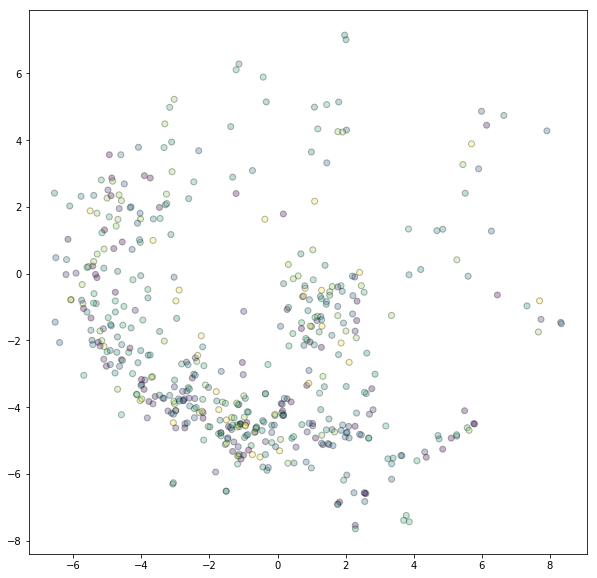

In [9]:
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(proj[:,1][:500], proj[:,0][:500], c=labels.ravel()[:500], alpha=0.3, edgecolor='k')
plt.show()

In [10]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 2.5})

In [11]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    return f, ax, sc

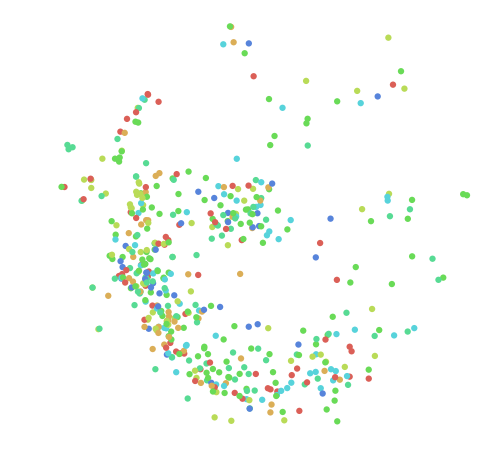

In [12]:
scatter(proj[:500], labels.ravel()[:500])
plt.savefig('digits_tsne-generated.png', dpi=120)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [14]:
clf = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
clf.fit(embedding[["x_" + str(x) for x in range(embedd_dim)]].values, labels)
predict = clf.predict(embedding[["x_" + str(x) for x in range(embedd_dim)]].values)

In [15]:
print ("Train F1:", f1_score(labels, predict, average="micro"))

Train F1: 0.4582717872968981
